In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- Unzip the dataset ---
# IMPORTANT: Update this path to match the location of your zip file in Drive.
zip_path = '/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/ffhq256_10ksubset.zip'

# The destination folder in the local Colab environment
destination_path = '/content'

print("Unzipping dataset...")
# The -q flag makes the output cleaner (quiet mode)
!unzip -q {zip_path} -d {destination_path}

print(f"✅ Dataset unzipped to {destination_path}")

Unzipping dataset...
✅ Dataset unzipped to /content


In [20]:
# Install
!pip -q install pytorch_wavelets torchmetrics lpips torch-fidelity pytorch-fid

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch._dynamo
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils import spectral_norm
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
import pandas as pd
import time
import random
import math
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm
import os
import glob
import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips

import torch.fft
from pytorch_wavelets import DWTForward
from einops import rearrange

import scipy.stats as stats
from skimage.metrics import structural_similarity as ssim
from pytorch_fid import fid_score

# Enable TensorFloat32
torch.set_float32_matmul_precision('high')

# --- Configuration & Hyperparameters ---

# Set the path to your image folder in Google Drive
# IMPORTANT: Update this path to match where you saved your dataset.
DATASET_PATH = '/content/ffhq_subset_10k'
NUM_IMAGES_TO_USE_CNN = 10000
NUM_IMAGES_TO_USE_GAN = 1000

# Training settings
NUM_EPOCHS_CNN = 40
NUM_EPOCHS_GAN = 200
LEARNING_RATE = 1e-4
BATCH_SIZE = 4

# Set the device (use GPU if available)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
class FFHQDataset(Dataset):
    """Custom PyTorch Dataset for loading FFHQ images."""
    def __init__(self, img_dir, transform=None, num_images=None): # Add num_images parameter
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_images (int, optional): Number of images to use. If None, use all images.
        """
        # Find all files with .png or .jpg extension
        self.img_paths = glob.glob(os.path.join(img_dir, '*.png'))
        self.img_paths.extend(glob.glob(os.path.join(img_dir, '*.jpg')))
        self.transform = transform

        if num_images:
            # If a number is specified, shuffle all paths and take a random subset
            random.shuffle(self.img_paths)
            self.img_paths = self.img_paths[:num_images]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Your transform definition remains the same
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
def tensor_to_image(tensor):
    """
    Converts a PyTorch tensor to a displayable NumPy image.
    It denormalizes, moves to CPU, and changes dimension order.
    """
    # Denormalize the image from [-1, 1] to [0, 1]
    image = tensor * 0.5 + 0.5
    # Move tensor to CPU and convert to NumPy array
    image = image.cpu().numpy()
    # Transpose dimensions from (C, H, W) to (H, W, C) for plotting
    image = image.transpose(1, 2, 0)
    # Clip values to be in the valid [0, 1] range for images
    image = np.clip(image, 0, 1)
    return image

In [7]:
def create_mask(image, mask_percentage=0.025):
    """
    Creates masks that are more likely to cover facial features.
    """
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    # Face regions typically in center 60% of image
    center_bias = 0.3  # 30% border on each side

    for i in range(batch_size):
        mask_h = int(np.sqrt(height * width * mask_percentage))
        mask_w = mask_h

        # Bias towards center
        top_min = int(height * center_bias)
        top_max = int(height * (1 - center_bias)) - mask_h
        left_min = int(width * center_bias)
        left_max = int(width * (1 - center_bias)) - mask_w

        top = np.random.randint(top_min, max(top_min + 1, top_max))
        left = np.random.randint(left_min, max(left_min + 1, left_max))

        mask[i, :, top:top+mask_h, left:left+mask_w] = 0

    masked_image = image * mask
    return masked_image, mask

In [9]:
class SelfAttention(nn.Module):
    """ A simple self-attention layer """
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key   = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        q = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch_size, -1, width * height)
        v = self.value(x).view(batch_size, -1, width * height)

        attention_map = F.softmax(torch.bmm(q, k), dim=-1)

        out = torch.bmm(v, attention_map.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x # Add skip connection

class UpsampleBlock(nn.Module):
    """An upsampling block using Conv2d and PixelShuffle."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The Conv2d layer produces 4x the channels for a 2x upscale
        self.conv = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2) # Rearranges channels to upscale by 2x
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.pixel_shuffle(self.conv(x)))

class GatedConv2d(nn.Module):
    """
    A Gated Convolutional Layer.
    It learns a dynamic feature mask for each channel at every location.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super().__init__()
        # Convolution for the features
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )
        # Convolution for the gating mechanism
        self.conv_gate = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )

    def forward(self, x):
        # Get the features and the gate
        features = self.conv_feature(x)
        gate = torch.sigmoid(self.conv_gate(x)) # Gate values are between 0 and 1

        # Element-wise multiplication to apply the learned gate
        return features * gate

class GatedResidualBlock(nn.Module):
    """A Residual Block that uses Gated Convolutions."""
    def __init__(self, channels, dilation=1):
        super().__init__()
        padding = dilation

        # Replace nn.Conv2d with GatedConv2d
        self.conv1 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual  # Residual connection
        out = self.relu(out)
        return out

class UNetSR(nn.Module):
    """
    A U-Net architecture with corrected channel dimensions for the decoder.
    """
    def __init__(self, in_channels=4, out_channels=3, num_channels=64):
        super().__init__()

        # --- Initial Convolution ---
        self.init_conv = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1)

        # --- Encoder Path ---
        self.enc1 = GatedResidualBlock(num_channels, dilation=1)
        self.enc2 = GatedResidualBlock(num_channels, dilation=1)
        self.pool = nn.MaxPool2d(2)

        # --- Bottleneck with Dilation and Attention ---
        self.bottleneck = nn.Sequential(
            GatedResidualBlock(num_channels, dilation=2),
            # SelfAttention(num_channels), # Add attention layer
            GatedResidualBlock(num_channels, dilation=4)
        )

        # --- Decoder Path ---
        self.upconv2 = UpsampleBlock(num_channels, num_channels)
        # Input channels = upsampled (64) + skip connection from e2 (64) = 128
        self.dec2 = GatedResidualBlock(num_channels * 2, dilation=1)

        self.upconv1 = UpsampleBlock(num_channels * 2, num_channels)
        # Input channels = upsampled (64) + skip connection from e1 (64) = 128
        self.dec1 = GatedResidualBlock(num_channels * 2, dilation=1)

        # --- Final Output Layer ---
        # The input to this layer comes from dec1, which outputs 128 channels.
        self.out_conv = nn.Conv2d(num_channels * 2, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial feature extraction
        x0 = self.init_conv(x)

        # Encoder
        e1 = self.enc1(x0)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder with Skip Connections
        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final Output
        out = self.out_conv(d1)

        return torch.tanh(out)

In [10]:
# --- 1. Create the main dataset ---
# This should use the LARGER number of images you intend to work with.
# Let's assume NUM_IMAGES_TO_USE_CNN is the total pool of images.
print("Creating the main dataset...")
full_dataset = FFHQDataset(
    img_dir=DATASET_PATH,
    transform=transform,
    num_images=NUM_IMAGES_TO_USE_CNN # Use the total number of images available for the experiment
)
print(f"✅ Main dataset created with {len(full_dataset)} images.")

# --- 2. Split the dataset into Training, Validation, and Test sets ---
print("\nSplitting data into training, validation, and test sets...")
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.seed(42) # for reproducibility
np.random.shuffle(indices)

# Define split points for an 80/10/10 split
train_split = int(np.floor(0.8 * dataset_size))
val_split = int(np.floor(0.9 * dataset_size))

# Create indices for each set
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create PyTorch Subsets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

print(f"✅ Training set size: {len(train_data)}")
print(f"✅ Validation set size: {len(val_data)}")
print(f"✅ Test set size: {len(test_data)}")

# --- 3. Create the Diffusion Model's training subset ---
# This should be a subset of the TRAINING data.
print("\nCreating a subset of the training data for the GAN model...")
gan_indices = train_indices[:NUM_IMAGES_TO_USE_GAN] # Take from the start of shuffled train indices
gan_data = Subset(full_dataset, gan_indices)
print(f"✅ Diffusion training set size: {len(gan_data)}")


# --- 4. Create DataLoaders for each set ---
print("\nCreating DataLoaders...")
# The main CNN will now train on the 'train_data' subset
cnn_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# New DataLoader for validation
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)
# New DataLoader for testing
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)
# GAN DataLoader uses its own subset of the training data
gan_dataloader = DataLoader(
    gan_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)
print("✅ All DataLoaders created.")

# --- 5. Initialize models and optimizers (unchanged) ---
print("\nInitializing models and optimizers...")
cnn_model = UNetSR().to(DEVICE)

# Compile the models for a speed boost
cnn_model = torch.compile(cnn_model)

# Initialize optimizers
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

print("\nSetup complete. Ready for CNN training!")

Creating the main dataset...
✅ Main dataset created with 10000 images.

Splitting data into training, validation, and test sets...
✅ Training set size: 8000
✅ Validation set size: 1000
✅ Test set size: 1000

Creating a subset of the training data for the GAN model...
✅ Diffusion training set size: 1000

Creating DataLoaders...
✅ All DataLoaders created.

Initializing models and optimizers...

Setup complete. Ready for CNN training!


In [11]:
# ============================================
# 1. GENERATOR - Residual Refinement Network
# ============================================

class ResidualBlock(nn.Module):
    """Residual block with spectral normalization"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = spectral_norm(nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv2 = spectral_norm(nn.Conv2d(channels, channels, 3, 1, 1))
        self.norm1 = nn.InstanceNorm2d(channels)
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.norm1(self.conv1(x)), 0.2)
        x = self.norm2(self.conv2(x))
        return x + residual

class SelfAttention(nn.Module):
    """Self-attention layer for capturing long-range dependencies"""
    def __init__(self, channels):
        super().__init__()
        self.query = spectral_norm(nn.Conv2d(channels, channels // 8, 1))
        self.key = spectral_norm(nn.Conv2d(channels, channels // 8, 1))
        self.value = spectral_norm(nn.Conv2d(channels, channels, 1))
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.shape

        q = self.query(x).view(b, -1, h * w).permute(0, 2, 1)
        k = self.key(x).view(b, -1, h * w)
        v = self.value(x).view(b, -1, h * w)

        attention = F.softmax(torch.bmm(q, k), dim=-1)
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(b, c, h, w)

        return self.gamma * out + x

class RefinementGenerator(nn.Module):
    """Generator that refines CNN output"""
    def __init__(self, in_channels=7, out_channels=3, base_channels=64):
        super().__init__()

        # Input: CNN output (3) + original masked (3) + mask (1) = 7 channels
        self.encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 7, 1, 3)),
            nn.LeakyReLU(0.2, True)
        )

        # Downsampling
        self.down1 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True)
        )

        self.down2 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, True)
        )

        # Residual blocks with attention
        self.res_blocks = nn.Sequential(
            ResidualBlock(base_channels * 4),
            ResidualBlock(base_channels * 4),
            SelfAttention(base_channels * 4),
            ResidualBlock(base_channels * 4),
            ResidualBlock(base_channels * 4),
        )

        # Upsampling
        self.up1 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True)
        )

        self.up2 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels),
            nn.LeakyReLU(0.2, True)
        )

        # Output residual
        self.output = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, out_channels, 7, 1, 3)),
            nn.Tanh()
        )

        # Learnable residual weight
        self.residual_weight = nn.Parameter(torch.tensor(0.01))

    def forward(self, cnn_output, masked_image, mask):
        """
        Args:
            cnn_output: CNN's coarse prediction [B, 3, H, W]
            masked_image: Original image with mask applied [B, 3, H, W]
            mask: Binary mask [B, 1, H, W]
        """
        # Concatenate inputs
        x = torch.cat([cnn_output, masked_image, mask], dim=1)

        # Encode
        x = self.encoder(x)

        # Downsample
        d1 = self.down1(x)
        d2 = self.down2(d1)

        # Process with residual blocks
        x = self.res_blocks(d2)

        # Upsample with skip connections
        x = self.up1(x)
        x = self.up2(x + d1)  # Skip connection

        # Generate residual
        residual = self.output(x)

        # Add weighted residual to CNN output
        refined = cnn_output + self.residual_weight * residual

        # Ensure output is in [-1, 1]
        return torch.tanh(refined)

In [12]:
# ============================================
# 2. DISCRIMINATOR - Multi-scale PatchGAN
# ============================================

class MultiscaleDiscriminator(nn.Module):
    """Multi-scale discriminator for better gradient flow"""
    def __init__(self, in_channels=3, base_channels=64, num_scales=3):
        super().__init__()

        self.num_scales = num_scales
        self.discriminators = nn.ModuleList()

        for _ in range(num_scales):
            self.discriminators.append(self._make_discriminator(in_channels, base_channels))

        self.downsample = nn.AvgPool2d(2)

    def _make_discriminator(self, in_channels, base_channels):
        return nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 4, 2, 1)),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 4, base_channels * 8, 4, 1, 1)),
            nn.InstanceNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 8, 1, 4, 1, 1))
        )

    def forward(self, x):
        outputs = []

        for i in range(self.num_scales):
            outputs.append(self.discriminators[i](x))
            if i < self.num_scales - 1:
                x = self.downsample(x)

        return outputs

In [13]:
# ============================================
# 3. LOSS FUNCTIONS
# ============================================

class PerceptualLoss(nn.Module):
    """VGG-based perceptual loss"""
    def __init__(self):
        super().__init__()
        import torchvision.models as models
        from torchvision.models import VGG19_Weights

        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features

        # Extract specific layers
        self.layers = nn.ModuleList([
            vgg[:4],   # relu1_2
            vgg[4:9],  # relu2_2
            vgg[9:18], # relu3_4
        ])

        # Freeze VGG
        for param in self.parameters():
            param.requires_grad = False

        # Normalization
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, pred, target):
        # Normalize from [-1, 1] to [0, 1]
        pred = (pred + 1) / 2
        target = (target + 1) / 2

        # VGG normalization
        pred = (pred - self.mean) / self.std
        target = (target - self.mean) / self.std

        loss = 0
        x_pred, x_target = pred, target

        for layer in self.layers:
            x_pred = layer(x_pred)
            x_target = layer(x_target)
            loss += F.l1_loss(x_pred, x_target)

        return loss

def hinge_loss_d(real_pred, fake_pred):
    """Hinge loss for discriminator"""
    loss = 0
    for real_p, fake_p in zip(real_pred, fake_pred):
        loss += torch.mean(F.relu(1 - real_p)) + torch.mean(F.relu(1 + fake_p))
    return loss / len(real_pred)

def hinge_loss_g(fake_pred):
    """Hinge loss for generator"""
    loss = 0
    for fake_p in fake_pred:
        loss += -torch.mean(fake_p)
    return loss / len(fake_pred)

In [14]:
# ============================================
# 4. TRAINING FUNCTION
# ============================================

def train_gan(generator, discriminator, cnn_model, train_loader, val_loader,
              num_epochs=80, device='cuda'):
    """Train the GAN for refinement"""

    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.999))

    # Add GradScalers for mixed precision
    g_scaler = torch.amp.GradScaler('cuda')
    d_scaler = torch.amp.GradScaler('cuda')

    # Loss functions
    l1_loss = nn.L1Loss()
    perceptual_loss = PerceptualLoss().to(device)

    # Training history
    history = {'g_loss': [], 'd_loss': [], 'val_psnr': []}

    # Training loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, batch in enumerate(pbar):
            real_images = batch.to(device)
            batch_size = real_images.size(0)

            # Create masks and get CNN predictions
            with torch.no_grad():
                masked_images, masks = create_mask(real_images, mask_percentage=0.025)
                masks = masks.to(device)

                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                coarse_output = cnn_model(cnn_input)

            # ==================
            # Train Discriminator
            # ==================
            d_optimizer.zero_grad()

            # Wrap forward passes in autocast
            with torch.amp.autocast('cuda'):
                # Generate refined images
                refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

                # Discriminator predictions
                real_pred = discriminator(real_images)
                fake_pred = discriminator(refined_images.detach())

                # Hinge loss
                d_loss = hinge_loss_d(real_pred, fake_pred)

            # Use scaler for backward pass
            d_scaler.scale(d_loss).backward()
            d_scaler.step(d_optimizer)
            d_scaler.update()

            # ==================
            # Train Generator
            # ==================
            # Train generator every 1 discriminator steps
            # Modified loss to heavily prioritize hole improvement
            if batch_idx % 1 == 0:
                g_optimizer.zero_grad()

                with torch.amp.autocast('cuda'):
                    refined_images = generator(coarse_output, masked_images, masks[:, 0:1])
                    fake_pred = discriminator(refined_images)

                    # AGGRESSIVE HOLE FOCUS:
                    hole_mask = 1 - masks
                    valid_mask = masks

                    # 1. Adversarial - let it be stronger for realism
                    g_adv_loss = hinge_loss_g(fake_pred) * 0.1

                    # 2. Hole-only reconstruction (PRIMARY LOSS)
                    g_hole_loss = l1_loss(refined_images * hole_mask, real_images * hole_mask) * 200  # HUGE weight

                    # 3. Perceptual loss ONLY in holes
                    g_perc_hole = perceptual_loss(refined_images * hole_mask, real_images * hole_mask) * 1.0

                    # 4. Edge/boundary loss for better blending
                    dilated_mask = F.max_pool2d(1 - masks[:, 0:1], 5, stride=1, padding=2)
                    boundary = dilated_mask - (1 - masks[:, 0:1])
                    g_boundary_loss = l1_loss(refined_images * boundary, real_images * boundary) * 50

                    # 5. Small penalty for changing non-hole regions
                    g_preserve_loss = l1_loss(refined_images * valid_mask, coarse_output * valid_mask) * 10

                    # Total loss focuses on improving holes
                    g_loss = g_adv_loss + g_hole_loss + g_perc_hole + g_boundary_loss + g_preserve_loss

                # Use scaler for backward pass
                g_scaler.scale(g_loss).backward()
                g_scaler.step(g_optimizer)
                g_scaler.update()

                # Update residual weight (optional)
                generator.residual_weight.data.clamp_(0.01, 0.1)

            # Update progress bar
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            pbar.set_postfix({
                'G': f'{g_loss.item():.4f}',
                'D': f'{d_loss.item():.4f}',
                'α': f'{generator.residual_weight.item():.3f}'
            })

        # Validation
        if epoch % 5 == 0:
            val_psnr = validate_gan(generator, cnn_model, val_loader, device)
            history['val_psnr'].append(val_psnr)
            print(f"\nValidation PSNR: {val_psnr:.2f} dB")

            # Save sample images
            save_samples(generator, cnn_model, val_loader, epoch, device)

        # Save checkpoint with scaler states
        if epoch % 10 == 0:
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optimizer': g_optimizer.state_dict(),
                'd_optimizer': d_optimizer.state_dict(),
                'g_scaler': g_scaler.state_dict(),  # Save scaler state
                'd_scaler': d_scaler.state_dict(),  # Save scaler state
                'epoch': epoch
            }, f'gan_checkpoint_epoch_{epoch}.pth')

        history['g_loss'].append(epoch_g_loss / len(train_loader))
        history['d_loss'].append(epoch_d_loss / len(train_loader))

    return history

# ============================================
# 5. VALIDATION AND INFERENCE
# ============================================

def validate_gan(generator, cnn_model, val_loader, device):
    """Calculate validation metrics with mixed precision"""
    generator.eval()
    total_psnr = 0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            real_images = batch.to(device)

            # Add autocast for validation too
            with torch.amp.autocast('cuda'):
                masked_images, masks = create_mask(real_images, mask_percentage=0.025)
                masks = masks.to(device)

                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                coarse_output = cnn_model(cnn_input)

                refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

            # Calculate metrics in FP32 (outside autocast)
            mse = F.mse_loss((refined_images + 1) / 2, (real_images + 1) / 2)
            psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)

            total_psnr += psnr.item() * real_images.size(0)
            count += real_images.size(0)

    return total_psnr / count

def save_samples(generator, cnn_model, val_loader, epoch, device):
    """Save sample images"""
    generator.eval()

    with torch.no_grad():
        batch = next(iter(val_loader))
        real_images = batch[:4].to(device)

        # Create masks and get CNN predictions
        masked_images, masks = create_mask(real_images, mask_percentage=0.025)
        masks = masks.to(device)

        cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
        coarse_output = cnn_model(cnn_input)

        # Generate refined images
        refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

        # Create comparison grid
        comparison = torch.cat([
            (real_images + 1) / 2,
            (masked_images + 1) / 2,
            (coarse_output + 1) / 2,
            (refined_images + 1) / 2
        ], dim=0)

        save_image(comparison, f'gan_samples_epoch_{epoch}.png', nrow=4)

# ============================================
# 6. INFERENCE FUNCTION
# ============================================

def inference_gan(generator, cnn_model, image, mask, device):
    """Run inference with the trained GAN"""
    generator.eval()
    cnn_model.eval()

    with torch.no_grad():
        # Get CNN prediction
        masked_image = image * mask
        cnn_input = torch.cat([masked_image, mask[:, 0:1]], dim=1)
        coarse_output = cnn_model(cnn_input)

        # Refine with GAN
        refined = generator(coarse_output, masked_image, mask[:, 0:1])

        # Ensure unmasked regions are preserved
        final_output = refined * (1 - mask) + image * mask

        return final_output, coarse_output

In [15]:
# ============================================
# USAGE
# ============================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
generator = RefinementGenerator(in_channels=7, out_channels=3).to(device)
discriminator = MultiscaleDiscriminator(in_channels=3).to(device)

# Load your pre-trained CNN
cnn_model = UNetSR().to(device)  # Use the same initialization as training!

# Load and fix the state dict
cnn_state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/final_cnn_model.pth', map_location=device)

# Remove _orig_mod. prefix if it exists
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}

# Now load the fixed state dict
cnn_model.load_state_dict(cnn_state_dict)

# Set to eval and freeze
cnn_model.eval()
for param in cnn_model.parameters():
    param.requires_grad = False

print("✅ CNN loaded successfully")

# Train
history = train_gan(
    generator,
    discriminator,
    cnn_model,
    train_loader=gan_dataloader,
    val_loader=val_dataloader,
    num_epochs=80,
    device=device
)

# Save final models
torch.save(generator.state_dict(), 'gan_generator_final.pth')
torch.save(discriminator.state_dict(), 'gan_discriminator_final.pth')

✅ CNN loaded successfully


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 233MB/s]


Epoch 1/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 26.85 dB


Epoch 2/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 27.33 dB


Epoch 7/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 27.77 dB


Epoch 12/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 28.15 dB


Epoch 17/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 21/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 28.54 dB


Epoch 22/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 23/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 24/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 25/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 26/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 28.93 dB


Epoch 27/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 28/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 29/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 30/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 31/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.12 dB


Epoch 32/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 33/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 34/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 35/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 36/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.20 dB


Epoch 37/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 38/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 39/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 40/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 41/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.06 dB


Epoch 42/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 43/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 44/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 45/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 46/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.17 dB


Epoch 47/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 48/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 49/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 50/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 51/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.20 dB


Epoch 52/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 53/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 54/80:   0%|          | 0/31 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Evaluation and Visualization

In [16]:
class ComprehensiveMetrics:
    """Extended metrics for thorough evaluation"""

    def __init__(self, device='cuda'):
        self.device = device
        self.psnr = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(device)
        self.ssim = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        self.lpips = lpips.LPIPS(net='alex').to(device)

        # FIX: Use smaller kernel size or make it optional
        try:
            self.ms_ssim = torchmetrics.MultiScaleStructuralSimilarityIndexMeasure(
                data_range=1.0,
                kernel_size=7,  # Reduced from 11 to 7
                betas=(0.0448, 0.2856, 0.3001, 0.2363, 0.1333)
            ).to(device)
            self.ms_ssim_available = True
        except:
            self.ms_ssim_available = False
            print("MS-SSIM not available, skipping...")

    def calculate_all_metrics(self, pred, target, mask=None):
        """Calculate comprehensive metrics"""
        metrics = {}

        # FIX: Ensure proper dimensions
        if pred.dim() == 3:
            pred = pred.unsqueeze(0)
        if target.dim() == 3:
            target = target.unsqueeze(0)

        # Convert to [0,1] range
        pred_01 = (pred + 1) / 2
        target_01 = (target + 1) / 2

        # Basic metrics
        metrics['psnr'] = self.psnr(pred_01, target_01).item()
        metrics['ssim'] = self.ssim(pred_01, target_01).item()

        # FIX: Only calculate MS-SSIM if image is large enough
        if self.ms_ssim_available and pred_01.shape[2] >= 160 and pred_01.shape[3] >= 160:
            try:
                metrics['ms_ssim'] = self.ms_ssim(pred_01, target_01).item()
            except:
                metrics['ms_ssim'] = metrics['ssim']  # Fallback to regular SSIM
        else:
            metrics['ms_ssim'] = metrics['ssim']  # Use regular SSIM for small images

        metrics['lpips'] = self.lpips(pred, target).mean().item()
        metrics['mae'] = F.l1_loss(pred_01, target_01).item()
        metrics['mse'] = F.mse_loss(pred_01, target_01).item()

        # Gradient difference (edge preservation)
        pred_grad = self._compute_gradient(pred)
        target_grad = self._compute_gradient(target)
        metrics['grad_diff'] = F.l1_loss(pred_grad, target_grad).item()

        # If mask provided, calculate region-specific metrics
        if mask is not None:
            # FIX: Ensure mask has proper dimensions
            if mask.dim() == 3:
                mask = mask.unsqueeze(0)

            # Ensure mask is single channel for calculations
            if mask.shape[1] == 3:
                mask_single = mask[:, 0:1, :, :]
            else:
                mask_single = mask

            hole_mask = 1 - mask_single

            # Metrics for inpainted region only
            metrics['psnr_hole'] = self._masked_psnr(pred_01, target_01, hole_mask).item()
            metrics['ssim_hole'] = self._masked_ssim(pred_01, target_01, mask_single)

            # FIX: Check if there are any holes before calculating MAE
            if hole_mask.sum() > 0:
                metrics['mae_hole'] = (F.l1_loss(pred_01 * hole_mask, target_01 * hole_mask, reduction='sum') / hole_mask.sum()).item()
            else:
                metrics['mae_hole'] = 0.0

            # Boundary metrics (transition quality)
            boundary = self._get_boundary(mask_single)
            if boundary.sum() > 0:
                metrics['boundary_mae'] = (F.l1_loss(pred_01 * boundary, target_01 * boundary, reduction='sum') / boundary.sum()).item()
            else:
                metrics['boundary_mae'] = 0.0

        return metrics

    def _compute_gradient(self, x):
        """Compute image gradients using Sobel filter"""
        # FIX: Ensure proper batch dimension
        if x.dim() == 3:
            x = x.unsqueeze(0)

        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
                               dtype=torch.float32).view(1, 1, 3, 3).to(x.device)
        sobel_y = sobel_x.transpose(2, 3)

        # Apply to each channel
        grad_x = F.conv2d(x, sobel_x.repeat(3, 1, 1, 1), groups=3, padding=1)
        grad_y = F.conv2d(x, sobel_y.repeat(3, 1, 1, 1), groups=3, padding=1)

        return torch.sqrt(grad_x**2 + grad_y**2 + 1e-8)  # Add epsilon for stability

    def _get_boundary(self, mask, dilation_size=3):
        """Get boundary region of mask"""
        # Ensure mask is single channel and 4D
        if mask.dim() == 3:
            mask = mask.unsqueeze(0)
        if mask.dim() == 4 and mask.shape[1] == 3:
            mask = mask[:, 0:1, :, :]
        elif mask.dim() == 4 and mask.shape[1] != 1:
            mask = mask[:, 0:1, :, :]

        kernel = torch.ones(1, 1, dilation_size, dilation_size).to(mask.device)
        dilated = F.conv2d(mask, kernel, padding=dilation_size//2)
        dilated = (dilated > 0).float()

        eroded = F.conv2d(mask, kernel, padding=dilation_size//2)
        eroded = (eroded == dilation_size**2).float()

        boundary = dilated - eroded
        return boundary

    def _masked_psnr(self, pred, target, mask):
        """Calculate PSNR only in masked region"""
        # FIX: Ensure all have same dimensions
        if pred.dim() == 3:
            pred = pred.unsqueeze(0)
        if target.dim() == 3:
            target = target.unsqueeze(0)
        if mask.dim() == 3:
            mask = mask.unsqueeze(0)

        masked_pred = pred * mask
        masked_target = target * mask

        if mask.sum() > 0:
            mse = ((masked_pred - masked_target) ** 2).sum() / mask.sum()
            if mse > 0:
                return 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)
            else:
                return torch.tensor(40.0)  # Perfect reconstruction
        else:
            return torch.tensor(0.0)

    def _masked_ssim(self, pred, target, mask):
        """Calculate SSIM focusing on masked region"""
        # Ensure proper dimensions
        if pred.dim() == 3:
            pred = pred.unsqueeze(0)
        if target.dim() == 3:
            target = target.unsqueeze(0)
        if mask.dim() == 3:
            mask = mask.unsqueeze(0)

        # Handle multi-channel masks properly
        if mask.dim() == 4 and mask.shape[1] == 3:
            mask_single = mask[:, 0, :, :]
        elif mask.dim() == 4:
            mask_single = mask.squeeze(1) if mask.shape[1] == 1 else mask[:, 0, :, :]
        else:
            mask_single = mask

        # Find region containing mask
        coords = torch.where(mask_single > 0)
        if len(coords[0]) == 0 or len(coords[1]) == 0:
            # No mask region, return full SSIM
            return self.ssim(pred, target).item()

        # Get bounding box
        y_min, y_max = max(0, coords[0].min().item()), min(pred.shape[2], coords[0].max().item() + 1)
        x_min, x_max = max(0, coords[1].min().item()), min(pred.shape[3], coords[1].max().item() + 1)

        # Ensure we have a valid region
        if y_max - y_min < 11 or x_max - x_min < 11:
            # Region too small for SSIM, use MAE instead
            return 1.0 - F.l1_loss(pred, target).item()

        pred_crop = pred[:, :, y_min:y_max, x_min:x_max]
        target_crop = target[:, :, y_min:y_max, x_min:x_max]

        return self.ssim(pred_crop, target_crop).item()

In [17]:
def create_advanced_visualization(original, masked, cnn_output, gan_output, mask,
                                 metrics_cnn, metrics_gan, save_path='advanced_vis.png'):
    """Create comprehensive visualization with multiple analysis views"""

    fig = plt.figure(figsize=(35, 20))
    gs = fig.add_gridspec(5, 8, hspace=0.3, wspace=0.3)

    # Convert tensors to numpy
    def to_numpy(tensor):
        return ((tensor.cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0).numpy()

    original_np = to_numpy(original)
    masked_np = to_numpy(masked)
    cnn_np = to_numpy(cnn_output)
    gan_np = to_numpy(gan_output)
    mask_np = mask[0, 0].cpu().numpy()

    # Row 1: Main images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original_np)
    ax1.set_title('Original', fontsize=12, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(masked_np)
    ax2.set_title('Masked Input', fontsize=12)
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(cnn_np)
    ax3.set_title(f'CNN Output\nPSNR: {metrics_cnn["psnr"]:.2f}', fontsize=12)
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(gan_np)
    ax4.set_title(f'GAN Refined\nPSNR: {metrics_gan["psnr"]:.2f}', fontsize=12)
    ax4.axis('off')

    # Row 1: Difference/Error maps
    diff_cnn = np.abs(original_np - cnn_np).mean(axis=2)
    diff_gan = np.abs(original_np - gan_np).mean(axis=2)

    ax5 = fig.add_subplot(gs[0, 4])
    im5 = ax5.imshow(diff_cnn, cmap='hot', vmin=0, vmax=0.3)
    ax5.set_title('CNN Error Map', fontsize=12)
    ax5.axis('off')
    plt.colorbar(im5, ax=ax5, fraction=0.046)

    ax6 = fig.add_subplot(gs[0, 5])
    im6 = ax6.imshow(diff_gan, cmap='hot', vmin=0, vmax=0.3)
    ax6.set_title('GAN Error Map', fontsize=12)
    ax6.axis('off')
    plt.colorbar(im6, ax=ax6, fraction=0.046)

    # Row 1: Perceptual difference
    ax7 = fig.add_subplot(gs[0, 6:8])
    ax7.imshow(np.abs(cnn_np - gan_np).mean(axis=2), cmap='coolwarm', vmin=-0.1, vmax=0.1)
    ax7.set_title('CNN vs GAN Difference', fontsize=12)
    ax7.axis('off')

    # Row 2: Zoomed patches (find area with most difference)
    hole_coords = np.where(1 - mask_np > 0)
    if len(hole_coords[0]) > 0:
        # Find center of masked region
        cy, cx = hole_coords[0].mean().astype(int), hole_coords[1].mean().astype(int)
        patch_size = 50

        # Ensure patch is within bounds
        y1 = max(0, cy - patch_size)
        y2 = min(original_np.shape[0], cy + patch_size)
        x1 = max(0, cx - patch_size)
        x2 = min(original_np.shape[1], cx + patch_size)

        # Extract patches
        patches = [
            original_np[y1:y2, x1:x2],
            masked_np[y1:y2, x1:x2],
            cnn_np[y1:y2, x1:x2],
            gan_np[y1:y2, x1:x2]
        ]

        titles = ['Original Patch', 'Masked Patch', 'CNN Patch', 'GAN Patch']
        for i, (patch, title) in enumerate(zip(patches, titles)):
            ax = fig.add_subplot(gs[1, i])
            ax.imshow(patch)
            ax.set_title(title, fontsize=10)
            ax.axis('off')
            # Add red rectangle to show zoom area
            if i == 0:
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    fill=False, edgecolor='red', linewidth=2)
                ax1.add_patch(rect)

    # Row 2: Gradient/Edge analysis
    def compute_edges(img):
        gray = np.dot(img, [0.2989, 0.5870, 0.1140])
        from scipy import ndimage
        edges = ndimage.sobel(gray)
        return edges

    edges_original = compute_edges(original_np)
    edges_cnn = compute_edges(cnn_np)
    edges_gan = compute_edges(gan_np)

    ax_e1 = fig.add_subplot(gs[1, 4])
    ax_e1.imshow(edges_original, cmap='gray')
    ax_e1.set_title('Original Edges', fontsize=10)
    ax_e1.axis('off')

    ax_e2 = fig.add_subplot(gs[1, 5])
    ax_e2.imshow(edges_cnn, cmap='gray')
    ax_e2.set_title('CNN Edges', fontsize=10)
    ax_e2.axis('off')

    ax_e3 = fig.add_subplot(gs[1, 6])
    ax_e3.imshow(edges_gan, cmap='gray')
    ax_e3.set_title('GAN Edges', fontsize=10)
    ax_e3.axis('off')

    # Row 3: Histograms
    ax_hist = fig.add_subplot(gs[2, :4])
    for img, label, color in [(original_np, 'Original', 'blue'),
                              (cnn_np, 'CNN', 'orange'),
                              (gan_np, 'GAN', 'green')]:
        ax_hist.hist(img.flatten(), bins=50, alpha=0.5, label=label, color=color, density=True)
    ax_hist.set_xlabel('Pixel Value')
    ax_hist.set_ylabel('Density')
    ax_hist.set_title('Pixel Value Distribution')
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)

    # Row 3: Metrics radar chart
    ax_radar = fig.add_subplot(gs[2, 4:], projection='polar')

    metrics_to_plot = ['psnr', 'ssim', 'ms_ssim']
    if 'psnr_hole' in metrics_cnn:
        metrics_to_plot.extend(['psnr_hole', 'ssim_hole'])

    angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()

    # Normalize metrics for radar chart
    cnn_values = []
    gan_values = []
    for metric in metrics_to_plot:
        if metric in metrics_cnn:
            # Normalize to 0-1 scale
            if metric.startswith('psnr'):
                cnn_values.append(metrics_cnn[metric] / 40)  # Assuming max PSNR ~40
                gan_values.append(metrics_gan[metric] / 40)
            else:
                cnn_values.append(metrics_cnn[metric])
                gan_values.append(metrics_gan[metric])

    angles += angles[:1]
    cnn_values += cnn_values[:1]
    gan_values += gan_values[:1]

    ax_radar.plot(angles, cnn_values, 'o-', linewidth=2, label='CNN', color='orange')
    ax_radar.fill(angles, cnn_values, alpha=0.25, color='orange')
    ax_radar.plot(angles, gan_values, 'o-', linewidth=2, label='GAN', color='green')
    ax_radar.fill(angles, gan_values, alpha=0.25, color='green')

    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(metrics_to_plot)
    ax_radar.set_ylim(0, 1)
    ax_radar.legend(loc='upper right')
    ax_radar.set_title('Metrics Comparison', fontsize=12, pad=20)

    # Row 4-5: Detailed metrics table
    ax_table = fig.add_subplot(gs[3:, :])
    ax_table.axis('tight')
    ax_table.axis('off')

    # Create metrics table
    table_data = []
    table_data.append(['Metric', 'CNN', 'GAN', 'Improvement', 'Best'])

    for metric in metrics_cnn.keys():
        if metric in metrics_gan:
            cnn_val = metrics_cnn[metric]
            gan_val = metrics_gan[metric]

            # Determine if higher or lower is better
            if metric in ['lpips', 'mae', 'mse', 'grad_diff', 'boundary_mae', 'mae_hole']:
                improvement = cnn_val - gan_val
                better = '↓'
                best = 'GAN' if gan_val < cnn_val else 'CNN'
            else:
                improvement = gan_val - cnn_val
                better = '↑'
                best = 'GAN' if gan_val > cnn_val else 'CNN'

            # Format values
            if metric.startswith('time'):
                row = [metric, f'{cnn_val:.3f}s', f'{gan_val:.3f}s',
                      f'{improvement:+.3f}s {better}', best]
            else:
                row = [metric, f'{cnn_val:.4f}', f'{gan_val:.4f}',
                      f'{improvement:+.4f} {better}', best]

            table_data.append(row)

    table = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color code the header
    for i in range(5):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color code the best column
    for i in range(1, len(table_data)):
        if table_data[i][4] == 'GAN':
            table[(i, 4)].set_facecolor('#90EE90')
        else:
            table[(i, 4)].set_facecolor('#FFB6C1')

    plt.suptitle('Comprehensive Inpainting Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    return fig

In [18]:
def evaluate_with_statistics(model_cnn, model_gan, test_loader, num_samples=100):
    """Evaluate models with confidence intervals and statistical tests"""

    metrics_calc = ComprehensiveMetrics()
    results = {'cnn': [], 'gan': []}

    for i, batch in enumerate(tqdm(test_loader, desc="Statistical Evaluation")):
        if i >= num_samples // test_loader.batch_size:
            break

        images = batch.to('cuda')
        masked, masks = create_mask(images, mask_percentage=0.025)

        with torch.no_grad():
            # CNN inference
            cnn_input = torch.cat([masked, masks[:, 0:1]], dim=1)
            cnn_output = model_cnn(cnn_input)

            # GAN inference
            gan_output = model_gan(cnn_output, masked, masks[:, 0:1])

            # Calculate metrics for each image
            for j in range(images.shape[0]):
                metrics_cnn = metrics_calc.calculate_all_metrics(
                    cnn_output[j:j+1], images[j:j+1], masks[j:j+1]
                )
                metrics_gan = metrics_calc.calculate_all_metrics(
                    gan_output[j:j+1], images[j:j+1], masks[j:j+1]
                )

                results['cnn'].append(metrics_cnn)
                results['gan'].append(metrics_gan)

    # Statistical analysis
    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS WITH CONFIDENCE INTERVALS")
    print("="*70)

    metric_names = results['cnn'][0].keys()

    for metric in metric_names:
        cnn_values = [r[metric] for r in results['cnn']]
        gan_values = [r[metric] for r in results['gan']]

        # Calculate statistics
        cnn_mean = np.mean(cnn_values)
        cnn_std = np.std(cnn_values)
        cnn_ci = stats.t.interval(0.95, len(cnn_values)-1,
                                  loc=cnn_mean,
                                  scale=stats.sem(cnn_values))

        gan_mean = np.mean(gan_values)
        gan_std = np.std(gan_values)
        gan_ci = stats.t.interval(0.95, len(gan_values)-1,
                                  loc=gan_mean,
                                  scale=stats.sem(gan_values))

        # Paired t-test
        t_stat, p_value = stats.ttest_rel(gan_values, cnn_values)

        print(f"\n{metric.upper()}:")
        print(f"  CNN: {cnn_mean:.4f} ± {cnn_std:.4f} (95% CI: [{cnn_ci[0]:.4f}, {cnn_ci[1]:.4f}])")
        print(f"  GAN: {gan_mean:.4f} ± {gan_std:.4f} (95% CI: [{gan_ci[0]:.4f}, {gan_ci[1]:.4f}])")
        print(f"  Difference: {gan_mean - cnn_mean:+.4f}")
        print(f"  P-value: {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")

        # Effect size (Cohen's d)
        cohens_d = (gan_mean - cnn_mean) / np.sqrt((cnn_std**2 + gan_std**2) / 2)
        print(f"  Effect size (Cohen's d): {cohens_d:.3f}")

    return results

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `MultiScaleStructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `MultiScaleStructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Statistical Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]


STATISTICAL ANALYSIS WITH CONFIDENCE INTERVALS

PSNR:
  CNN: 39.4119 ± 2.8470 (95% CI: [39.0140, 39.8099])
  GAN: 29.7916 ± 3.0010 (95% CI: [29.3721, 30.2111])
  Difference: -9.6203
  P-value: 0.000000 ***
  Effect size (Cohen's d): -3.289

SSIM:
  CNN: 0.9886 ± 0.0102 (95% CI: [0.9871, 0.9900])
  GAN: 0.9297 ± 0.0677 (95% CI: [0.9202, 0.9392])
  Difference: -0.0589
  P-value: 0.000000 ***
  Effect size (Cohen's d): -1.216

MS_SSIM:
  CNN: 0.9949 ± 0.0027 (95% CI: [0.9945, 0.9952])
  GAN: 0.9781 ± 0.0119 (95% CI: [0.9764, 0.9797])
  Difference: -0.0168
  P-value: 0.000000 ***
  Effect size (Cohen's d): -1.954

LPIPS:
  CNN: 0.0095 ± 0.0051 (95% CI: [0.0088, 0.0102])
  GAN: 0.0344 ± 0.0136 (95% CI: [0.0325, 0.0363])
  Difference: +0.0249
  P-value: 0.000000 ***
  Effect size (Cohen's d): 2.415

MAE:
  CNN: 0.0036 ± 0.0008 (95% CI: [0.0035, 0.0037])
  GAN: 0.0213 ± 0.0099 (95% CI: [0.0199, 0.0227])
  Difference: +0.0177
  P-value: 0.000000 ***
  Effect size (Cohen's d): 2.521

MSE:
  CN

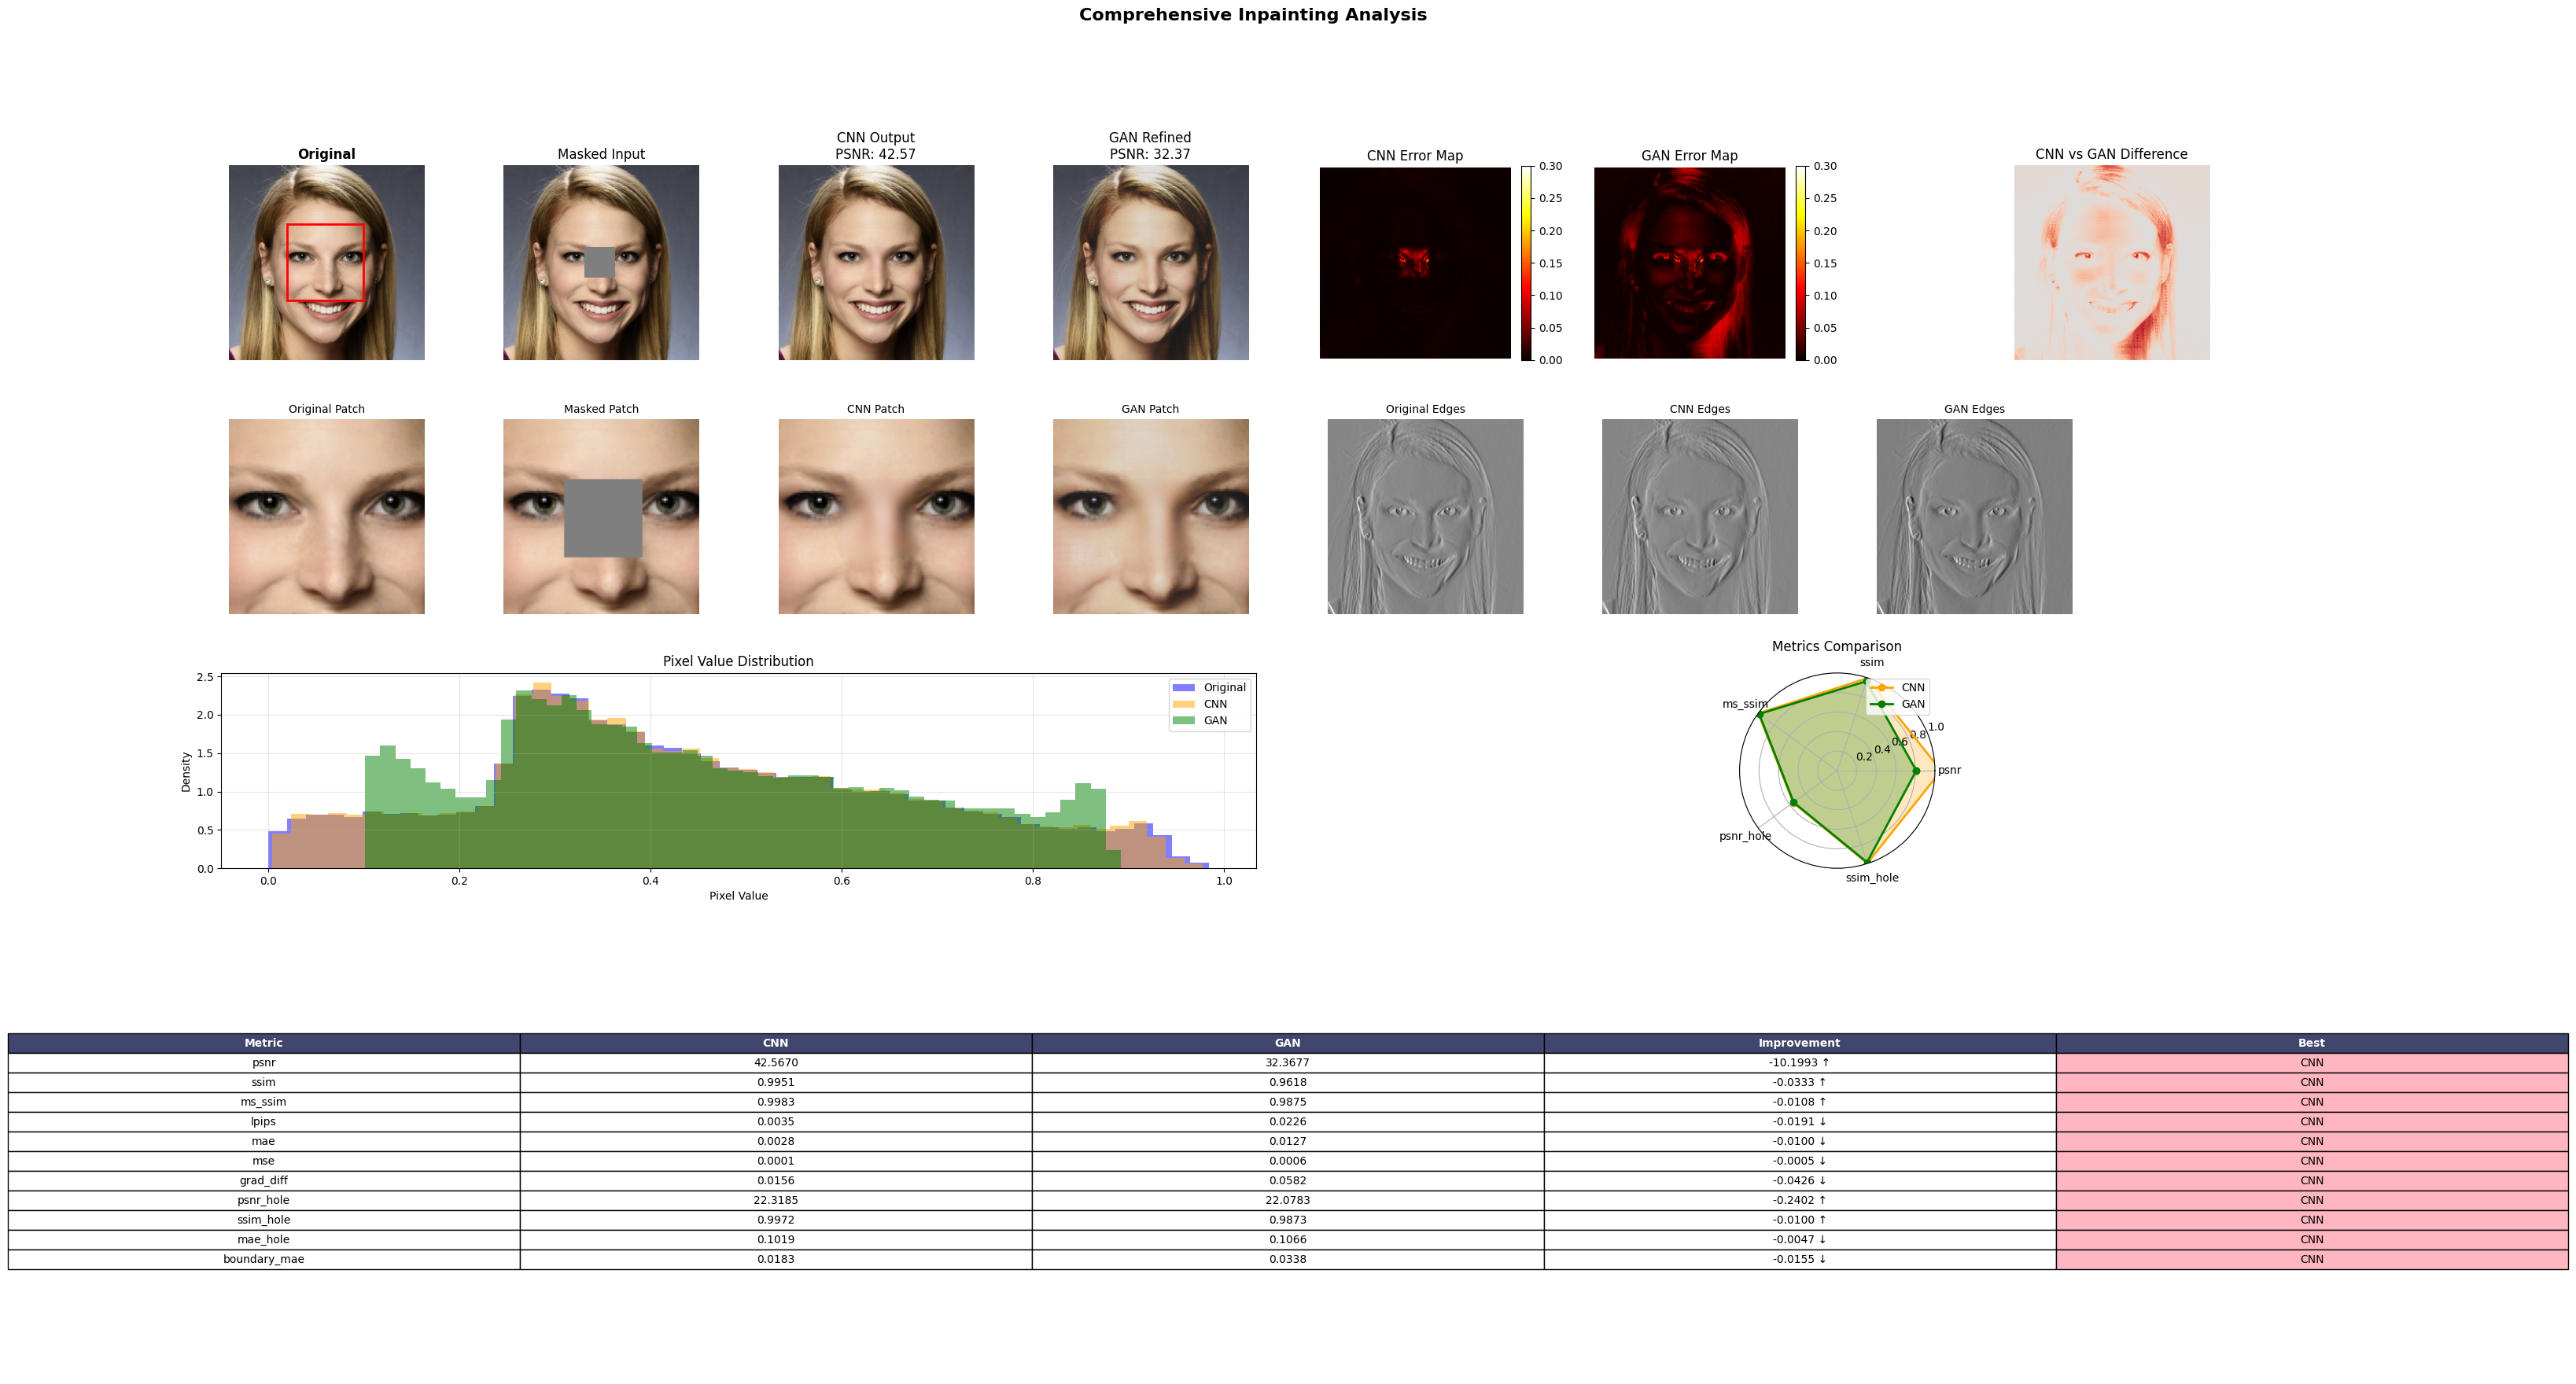

Evaluation complete!


In [30]:
########################
# USAGE
########################

# Initialize comprehensive metrics
metrics_calculator = ComprehensiveMetrics(device='cuda')

# Run statistical evaluation
results = evaluate_with_statistics(cnn_model, generator, test_dataloader, num_samples=200)

# Create advanced visualization for a sample
sample_batch = next(iter(test_dataloader))
sample_image = sample_batch[0:1].to('cuda')
masked, mask = create_mask(sample_image, mask_percentage=0.025)

with torch.no_grad():
    cnn_input = torch.cat([masked, mask[:, 0:1]], dim=1)
    cnn_output = cnn_model(cnn_input)
    gan_output = generator(cnn_output, masked, mask[:, 0:1])

    metrics_cnn = metrics_calculator.calculate_all_metrics(cnn_output, sample_image, mask)
    metrics_gan = metrics_calculator.calculate_all_metrics(gan_output, sample_image, mask)

# Create visualization
create_advanced_visualization(
    sample_image[0], masked[0], cnn_output[0], gan_output[0], mask,
    metrics_cnn, metrics_gan, save_path='advanced_analysis.png'
)

print("Evaluation complete!")